# A/B Testing in R

Nous effectuons l'analyse sur un jeu de données s'étalant sur 7 mois (juillet 2022 à janvier 2023)

In [3]:
# installation de packages et chargement de librairies 
install.packages("lmtest_0.9-40.tar.gz", repos = NULL, type = "source")
install.packages("sandwich_3.0-2.tar.gz", repos = NULL, type = "source")
#
library(lmtest)
library(sandwich)
library(tidyverse)

Installing package into ‘/home/repl/renv/library/R-4.2/x86_64-pc-linux-gnu’
(as ‘lib’ is unspecified)

Installing package into ‘/home/repl/renv/library/R-4.2/x86_64-pc-linux-gnu’
(as ‘lib’ is unspecified)



In [5]:
# Chargement de la table de données et affichage d'un échantillon aléatoire de 10 lignes 
customer_data <- read_csv("experiment_data.csv")
customer_data[sample(1:nrow(customer_data), size = 10), ]

Rows: 1500 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Group
dbl (4): Month, Treated, Dollars, id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Month,Group,Treated,Dollars,id
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
202301,Existing,0,42.15,283
202212,New,1,45.16,180
202207,Existing,0,55.29,222
202208,New,0,45.68,18
202210,Existing,0,35.62,310
202212,New,1,67.91,132
202207,New,0,36.28,175
202207,Existing,0,72.11,348
202209,Existing,0,49.38,258


La variable "Group" indique le produit acheté par le client (Ancien, Nouveau) 

la variable "Treated" indique le statut de chaque client par rapport à un traitement commercial.

la variable "Dollars" représente les dépenses des clients

id est un identifiant client

## Analyse exploratoire de la dataset

In [18]:
cat("nbr de lignes total et nbr de lignes distinct dans la dataset:\n")
dim(customer_data)[1]
nrow(distinct(customer_data)) # lignes uniques sans doublons
cat("\n nbr de mois distincts dans la dataset:\n")
nrow(distinct(customer_data, Month)) 
cat("\n nbr de clients distincts dans la dataset:\n")
nrow(distinct(customer_data, id)) 

cat("\n nbr de clients par groupe et par traitement:\n")
table(customer_data$Group) # Nbr de clients dans la dataset
cat("\n")
table(customer_data$Month, customer_data$Treated)

nbr de lignes total et nbr de lignes distinct dans la dataset:


[1] 1500

[1] 1500


 nbr de mois distincts dans la dataset:


[1] 7


 nbr de clients distincts dans la dataset:


[1] 398


 nbr de clients par groupe et par traitement:



Existing      New 
     791      709 

        
           0 0.5   1
  202207 205   0   0
  202208 211   0   0
  202209 207   0   0
  202210 112  95   0
  202211 109   0 105
  202212 120   0 110
  202301 123   0 103

## Aggrégeons les données par Month et par Group et regardons l'évolution de notre indicateur cible (les dépenses)

In [19]:
month_group_data <- customer_data %>%  group_by(Month, Group) %>%  summarize(Dollars = mean(Dollars), Treatment = mean(Treated))
month_group_data %>% arrange(Month, Group)

`summarise()` has grouped output by 'Month'. You can override using the
`.groups` argument.
New names:
• `` -> `...1`


Month,Group,Dollars,Treatment
<dbl>,<chr>,<dbl>,<dbl>
202207,Existing,52.34873,0.0
202207,New,47.11758,0.0
202208,Existing,49.44972,0.0
202208,New,47.79670,0.0
202209,Existing,48.44917,0.0
202209,New,49.57878,0.0
202210,Existing,46.25839,0.0
202210,New,49.84221,0.5
202211,Existing,49.05615,0.0


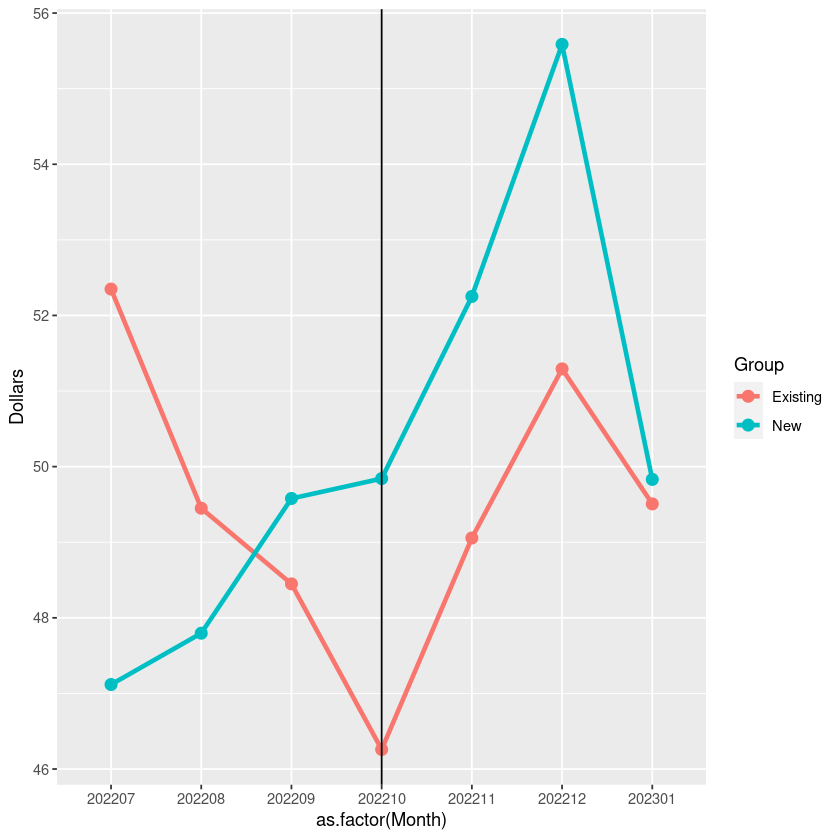

In [20]:
# Plot the time series using a line plot
time_series_plot = ggplot(month_group_data,
       aes(x = as.factor(Month),
           y = Dollars,
           color = Group,
           group = Group)) +  geom_point(size = 3) +  geom_line(linewidth = 1.3) + geom_vline(xintercept = 4) 
time_series_plot

In [35]:
# Supprimons le mois d'octobre de l'analyse (c'est le mois où l'expérimentation a été mis en place:ce qui fait que certains clients ont déjà vu le nouveau produit, d'autres non )
customer_data = customer_data %>% filter(Month != "202210")
# Ajouter un binaire pour indiquer la période réel à considérer pour le test A/B 
customer_data$AB_period = ifelse(customer_data$Month %in% c("202211", "202212", "202301"), 1, 0)
#
table(customer_data$Month, customer_data$AB_period)

        
           0   1
  202207 205   0
  202208 211   0
  202209 207   0
  202211   0 214
  202212   0 230
  202301   0 226

## Courbes de densité des dépenses sur la période réelle du test A/B (treated)

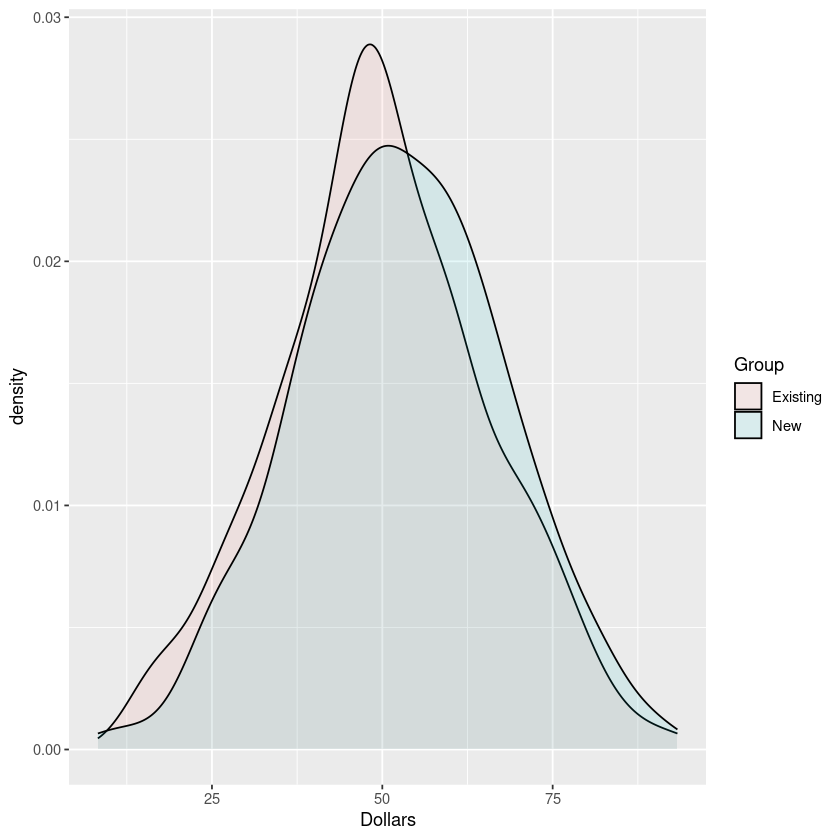

In [31]:
ggplot(customer_data %>% filter(AB_period == 1), aes(Dollars, fill = Group)) +
     geom_density(alpha = 0.1)

## Aggrégeons les dépenses par client par traitement et par groupe 

In [32]:
customer_data_aggregated = customer_data %>%  group_by(id, Treated, Group, AB_period) %>%  summarize(Dollars = mean(Dollars))
customer_data_aggregated = customer_data_aggregated %>% arrange(id, Treated, Group)
head(customer_data_aggregated)
tail(customer_data_aggregated)

`summarise()` has grouped output by 'id', 'Treated', 'Group'. You can override
using the `.groups` argument.
New names:
• `` -> `...1`


id,Treated,Group,AB_period,Dollars
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,0,New,0,44.12000
1,1,New,1,56.93667
2,0,New,0,61.12000
2,1,New,1,48.73667
3,0,New,0,65.37000
3,1,New,1,53.48500


New names:
• `` -> `...1`


id,Treated,Group,AB_period,Dollars
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
397,0,Existing,1,49.450
398,0,Existing,1,35.970
399,0,Existing,0,61.270
399,0,Existing,1,30.015
400,0,Existing,0,41.920
400,0,Existing,1,42.480


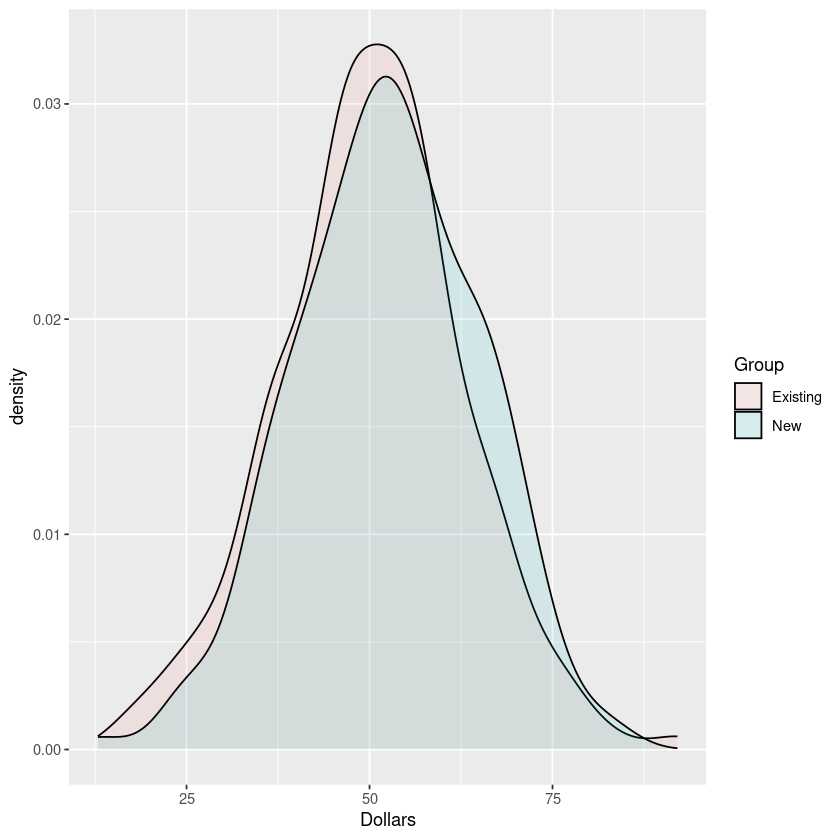

In [29]:
ggplot(customer_data_aggregated %>% filter(AB_period == 1), aes(Dollars, fill = Group)) +
     geom_density(alpha = 0.1)

## Test de comparaison des dépenses des clients sur le nouveau et sur l'ancien produit

In [104]:
t.test(
    customer_data_aggregated %>% filter(Group == "New" & AB_period == 1) %>% pull(Dollars),
    customer_data_aggregated %>% filter(Group == "Existing" & AB_period == 1) %>% pull(Dollars)
      )


	Welch Two Sample t-test

data:  customer_data_aggregated %>% filter(Group == "New" & AB_period == 1) %>% pull(Dollars) and customer_data_aggregated %>% filter(Group == "Existing" & AB_period == 1) %>% pull(Dollars)
t = 1.6855, df = 368, p-value = 0.09274
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3656609  4.7530882
sample estimates:
mean of x mean of y 
 52.42986  50.23615 


**Dans ce test p-value > 5% ,en conséquence, avec un risque d'erreur tolérable de 5% (seuil standard), on ne peut pas conclure à une différence significative des dépenses des clients entre l'ancien et le nouveau produit.** 

## Test de comparaison des dépenses exclusivement sur le nouveau produit avant et après le traitement  

In [103]:
t.test(
    customer_data_aggregated %>% filter(Group == "New" & Treated == 1) %>% pull(Dollars),
    customer_data_aggregated %>% filter(Group == "New" & Treated == 0) %>% pull(Dollars)
      )


	Welch Two Sample t-test

data:  customer_data_aggregated %>% filter(Group == "New" & Treated == 1) %>% pull(Dollars) and customer_data_aggregated %>% filter(Group == "New" & Treated == 0) %>% pull(Dollars)
t = 3.268, df = 350.19, p-value = 0.00119
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.818671 7.316318
sample estimates:
mean of x mean of y 
 52.42986  47.86237 


**Dans ce test p-value < 1% ,en conséquence, même avec un risque d'erreur tolérable limité à 1%, on peut conclure à une différence significative des dépenses des clients sur le nouveau produit entre la situation avant et après le traitement.**